In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_enumerator import get_aoi_dataframe, enumerate_by_tile, distill_all_pairs
import concurrent
from tqdm import tqdm
from s1_enumerator import duplicate_gunw_found

from shapely.geometry import Point
import datetime
import pandas as pd
import matplotlib.pyplot as plt

<AxesSubplot:>

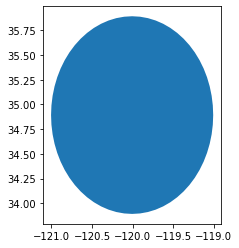

In [3]:
# Over Los Padres National Forest, CA
point = Point(-120.0048,34.8923)
aoi = point.buffer(1)
df_aoi = get_aoi_dataframe(aoi)
df_aoi.plot()

# Standard Product Enumeration

Gets all tiles that cover AOI and then find suitable sets to generate interferograms.

Specifics:

- Requires each tile has 80% overlap with AOI, relative to tile. Since S1 footprints are fixed this can be translated to absolute area. The percentage can be modified with keyword arguments.
- Requires secondary tiles to have at least 10% overlap with reference tile used for interferogram
- When comparing to the entire S1 catalog, it fixes the reference as the earliest date after `min_reference_date`.
- Due to the nuanced nature of enumeration, we download the metadata for *all the tiles* that intersect the AOI. We cannot use the current `ASF` stack because it assumes each date has a *single* intersection with the reference tile. We can sometimes use two secondary tiles to obtain sufficient coverage.

## Enumeration over 1 year

- `min_days_backward` refers to the fact all pairs will have at least a certain number of days between pairs. Secondary sets are selected as the latest dates that still have this space. 
- `num_neighbors` is the number of dates that can be used for interferograms. This will determine the number of interferograms that are generated. Generally (unless there is some unusual unavailability), the total number of interferograms (i.e. `len(ifg_pairs_tiles)` below) should be divisible by `num_neighbors`.

In [4]:
num_neighbors = 3
ifg_pairs_tiles = enumerate_by_tile(aoi,
                                    min_reference_date=datetime.datetime(2021, 7, 9), 
                                    min_days_backward = 365, 
                                    num_neighbors=num_neighbors,
                                    entire_s1_catalog=False
                                    )

1 period(s) of 365 days: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]


In [5]:
N = len(ifg_pairs_tiles)
print('total GUNWs (N): ', N)
print(f'Remainder of N with num_neighbors ({num_neighbors}): ', N % num_neighbors)

total GUNWs (N):  9
Remainder of N with num_neighbors (3):  0


<AxesSubplot:>

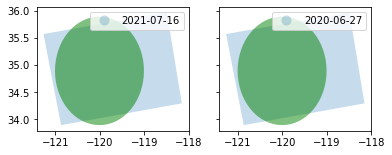

In [6]:
J = 7
pair = ifg_pairs_tiles[J]

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

df_ref_plot = pair['reference']
df_sec_plot = pair['secondary']

df_ref_plot.plot(column='start_date_str', 
                 legend=True, 
                 ax=axs[0], alpha=.25)
df_aoi.plot(ax=axs[0], alpha=.5, color='green')

df_sec_plot.plot(column='start_date_str', 
                 legend=True, 
                 ax=axs[1], alpha=.25)
df_aoi.plot(ax=axs[1], alpha=.5, color='green')

<AxesSubplot:>

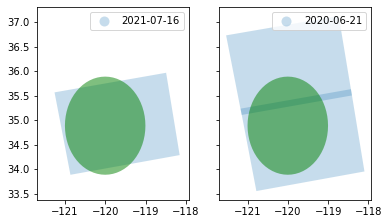

In [7]:
J = 8
pair = ifg_pairs_tiles[J]

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

df_ref_plot = pair['reference']
df_sec_plot = pair['secondary']

df_ref_plot.plot(column='start_date_str', 
                 legend=True, 
                 ax=axs[0], alpha=.25)
df_aoi.plot(ax=axs[0], alpha=.5, color='green')

df_sec_plot.plot(column='start_date_str', 
                 legend=True, 
                 ax=axs[1], alpha=.25)
df_aoi.plot(ax=axs[1], alpha=.5, color='green')

# Entire Catalog

Check the entire catalog.

In [8]:
ifg_pairs_tiles_all = enumerate_by_tile(aoi,
                                    min_reference_date=datetime.datetime(2021, 7, 9), 
                                    min_days_backward = 365, 
                                    num_neighbors=3,
                                    entire_s1_catalog=True
                                    )

5 period(s) of 365 days: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


In [9]:
ifg_pairs_tiles_all[0]['reference'].columns

Index(['index', 'beamModeType', 'browse', 'bytes', 'faradayRotation', 'fileID',
       'fileName', 'flightDirection', 'frameNumber', 'granuleType', 'groupID',
       'insarStackId', 'md5sum', 'offNadirAngle', 'orbit', 'pathNumber',
       'platform', 'pointingAngle', 'polarization', 'processingDate',
       'processingLevel', 'sceneName', 'sensor', 'startTime', 'stopTime',
       'url', 'geometry', 'start_date', 'start_date_str'],
      dtype='object')

# Format for API Calls

In [10]:
df_pairs = distill_all_pairs(ifg_pairs_tiles)

Save the file

In [11]:
df_tile_test = df_pairs.sort_values(by=['path_number', 'reference_date']).reset_index(drop=True)
df_tile_test.drop(columns=['reference', 'secondary']).to_file('enum_tile.geojson')

<AxesSubplot:>

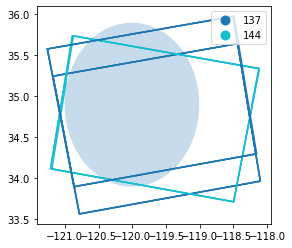

In [12]:
df_pairs_plot = df_pairs.copy()
df_pairs_plot.geometry = df_pairs.geometry.exterior

fig, ax = plt.subplots()
df_aoi.plot(alpha=.25, ax=ax)
df_pairs_plot.plot(column='path_number', categorical=True, legend=True, ax=ax)

In [13]:
records = df_pairs.to_dict('records')
records[:15]

[{'reference': ['S1A_IW_SLC__1SDV_20210710T015845_20210710T015913_038709_04915C_64A6'],
  'secondary': ['S1A_IW_SLC__1SDV_20200703T015838_20200703T015906_033284_03DB34_F8A3'],
  'reference_date': '2021-07-10',
  'secondary_date': '2020-07-03',
  'path_number': 137,
  'geometry': <shapely.geometry.polygon.Polygon at 0x1c4b7e790>},
 {'reference': ['S1A_IW_SLC__1SDV_20210710T015845_20210710T015913_038709_04915C_64A6'],
  'secondary': ['S1B_IW_SLC__1SDV_20200627T015734_20200627T015804_022213_02A288_062B',
   'S1B_IW_SLC__1SDV_20200627T015802_20200627T015830_022213_02A288_89D9'],
  'reference_date': '2021-07-10',
  'secondary_date': '2020-06-27',
  'path_number': 137,
  'geometry': <shapely.geometry.polygon.Polygon at 0x1c43b4700>},
 {'reference': ['S1A_IW_SLC__1SDV_20210710T015845_20210710T015913_038709_04915C_64A6'],
  'secondary': ['S1A_IW_SLC__1SDV_20200621T015838_20200621T015906_033109_03D5E6_7379'],
  'reference_date': '2021-07-10',
  'secondary_date': '2020-06-21',
  'path_number': 1

# ASF Lookup

In [14]:
K = 3
entry = records[K]
entry

{'reference': ['S1A_IW_SLC__1SDV_20210710T140037_20210710T140104_038716_049192_37DA'],
 'secondary': ['S1A_IW_SLC__1SDV_20200703T140031_20200703T140058_033291_03DB6C_F32C'],
 'reference_date': '2021-07-10',
 'secondary_date': '2020-07-03',
 'path_number': 144,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1c391b5e0>}

In [15]:
duplicate_gunw_found(entry)

'S1-GUNW-D-R-144-tops-20210710_20200703-140051-35745N_33766N-PP-12c6-v2_0_4'

In [16]:
with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    results = list(tqdm(executor.map(duplicate_gunw_found, records), total=len(records)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.58it/s]


In [17]:
results

['',
 '',
 '',
 'S1-GUNW-D-R-144-tops-20210710_20200703-140051-35745N_33766N-PP-12c6-v2_0_4',
 '',
 '',
 '',
 '',
 '']